In [1]:
import random
from tensorflow.keras.applications import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.initializers import *
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.optimizers import *
from convnets.utilities import utils_nets

In [2]:
# dimensions of our images.
img_width, img_height = 224, 224
train_data_dir = '../../../../data/passport_2class_divided_clean/train'
validation_data_dir = '../../../../data/passport_2class_divided_clean/validation'

weights_path_mcp = '../../../../data/weights/mobilenet/fine_tuned_mobilenet_passport.h5'
nb_train_samples = 480
nb_validation_samples = 130
epochs = 20
batch_size = 5

In [3]:
def train_model():
        # build the MobileNetV2 network
    base_model = mobilenet_v2.MobileNetV2(input_shape=(224, 224, 3), alpha=1.0, include_top=False, weights='imagenet')

    head_model = base_model.output
#     print(base_model.output.shape)
    head_model = GlobalAveragePooling2D()(head_model)
    head_model = Dense(1, activation='sigmoid')(head_model)
    model = Model(inputs= base_model.input, outputs= head_model)
    # for layer in base_model.layers:
    #     layer.trainable = False
    for layer in base_model.layers[:142]:
        layer.trainable = False
    model.summary()

    opt = Adam(learning_rate=1e-5)
    model.compile(optimizer=opt,
                  loss='binary_crossentropy', metrics=['accuracy'])
#     earlyStopping = EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='min')
#     reduce_lr_acc = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1, min_delta=1e-4, mode='max')
    mcp_save = ModelCheckpoint(weights_path_mcp, save_best_only=True, monitor='val_loss', mode='min')
    history = model.fit_generator(
            generator=train_generator,
            steps_per_epoch=nb_train_samples // batch_size,
            epochs=epochs,
             callbacks = [mcp_save],
            validation_data=val_generator,
            validation_steps=nb_validation_samples // batch_size)
    return model, history

In [4]:
train_generator, val_generator = utils_nets.init_generators(train_data_dir,
                                                       validation_data_dir,
                                                       img_width,
                                                       img_height,
                                                       batch_size,
                                                       batch_size)

Found 480 images belonging to 2 classes.
Found 130 images belonging to 2 classes.


In [5]:
model, history = train_model()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
______________________________________________________________________________________________

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


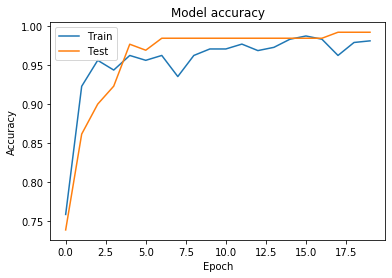

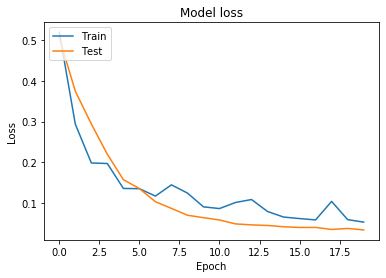

In [6]:
utils_nets.plot(history)
# model.save('/home/mksnkv/models/top_tuned/imagenetV2/whole_model_passport.h5')
# model.save_weights(weights_path)
# utils.save_model_structure_to_json(structure_path, model)
